<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L11/random_walk_value_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random walk state evaluation
In this exercise we'll try to evaluate the states of a problem using two methods:
* Iterative use of Bellman's equation.
  * In this case we use the Bellman's formula $$V^{\prime \pi}(s) \leftarrow \sum_{a \in \mathcal{A}} \pi(a\vert s)\left[r(s, a) + \gamma\sum_{s'} p(s'\vert s, a)V^{\pi}(s')\right]$$ iteratively, starting from a zero value for all the states.

* MonteCarlo evaluation
  * MonteCarlo evaluation is more general, we don't need transition matrices $p(s'\vert s, a)$ but we directly simulate the probelm several times and record the histories trajectories and rewards. The value is then assigned by walking the trajectories backward in time and updating the current state with a dumped update.

* Temporal differences
  * We don't need to wait until the end of the episode to perform an update, even in the sparse reward setting. We can apply bootstrap:
  $$v(s_t) = v(s_t) +  \alpha(r +\gamma v(s_{t+1}) - v(s_t))$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Environment setup
k = 10
start_state = 3
terminal_state = k - 1

def step(state, action):
    next_state = state + action
    next_state = max(0, min(terminal_state, next_state))
    reward = 1.0 if next_state == terminal_state else 0.0
    return next_state, reward

## ❓ Try to complete the following three methods

In [2]:
# Value Iteration
def value_iteration(states, gamma=1.0, theta=1e-6):
    V = np.zeros(states)
    V[-1] = 1
    delta = float('inf')
    v_history = []
    while delta > theta:
        delta = 0
        for s in range(1, terminal_state):
            v = V[s]
            ############ COMPLETE THIS PART ############
            V[s] = ???
            delta = max(delta, abs(v - V[s]))
        v_history.append(np.copy(V))
    return V, v_history

In [3]:
# Monte Carlo Estimation with incremental average
def monte_carlo_estimation(episodes=2000, gamma=1.0):
    V = np.zeros(k)
    N = np.zeros(k)
    trajectory_history = []
    v_history = []
    for _ in range(episodes):
        state = start_state
        trajectory = []
        while state != terminal_state and state != 0:
            action = np.random.choice([-1, 1])
            next_state, reward = step(state, action)
            state = next_state
            trajectory.append((state, reward))
        trajectory_history.append(np.array(trajectory))
        G = 0
        for t in reversed(range(len(trajectory))):
            state, reward = trajectory[t]
            ############ COMPLETE THIS PART ############
            G = ???
            N[state] += 1
            V[state] += ???
        v_history.append(V.copy())

    return V, v_history, trajectory_history

In [4]:
def td0_estimation(episodes=50, gamma=1.0, alpha=0.1):
    V = np.zeros(k)
    v_history = []
    for _ in range(episodes):
        state = start_state
        while state != terminal_state and state != 0:
            action = np.random.choice([-1, 1])
            next_state, reward = step(state, action)
            ############ COMPLETE THIS PART ############
            V[state] += ???
            state = next_state
        v_history.append(V.copy())
    return V, v_history

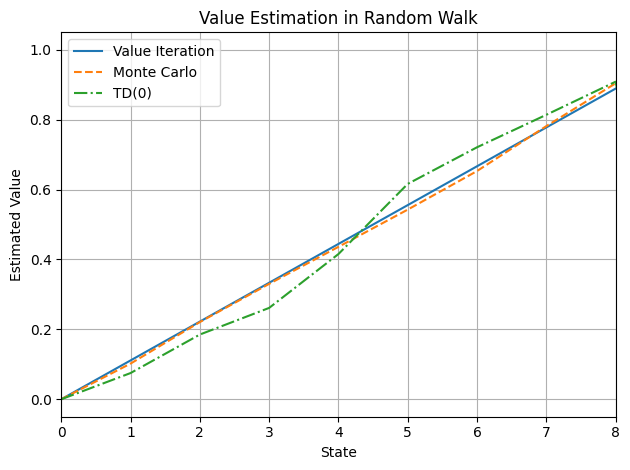

In [5]:
# Run value iteration and Monte Carlo estimation
V_vi, v_history = value_iteration(k)
V_mc, v_history_mc, trajectory_history = monte_carlo_estimation(episodes=1000)
V_td0, v_history_td0 = td0_estimation(episodes=1000)

# Plot the results
plt.plot(V_vi, label='Value Iteration')
plt.plot(V_mc, label='Monte Carlo', linestyle='--')
plt.plot(V_td0, label='TD(0)', linestyle='-.')
plt.xlim(0, k-2)
plt.xlabel('State')
plt.ylabel('Estimated Value')
plt.title('Value Estimation in Random Walk')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#@title VI animation

def animate_value_iteration(v_history):

  fig, ax = plt.subplots(figsize=(8, 4))
  bars = ax.bar(range(k), np.zeros(k))

  def init():
      ax.set_ylim(0, 1)
      ax.set_title("Value Iteration: Value Estimates")
      ax.set_xlabel("State")
      ax.set_ylabel("Value")
      return bars

  def update(frame):
      values = v_history[frame][:-1] if frame < len(v_history) else v_history[-1]
      for bar, val in zip(bars, values):
          bar.set_height(val)
      ax.set_title(f"Value Iteration Step {frame}")
      return bars

  plt.close()
  anim = FuncAnimation(fig, update, frames=100, init_func=init, blit=False)
  return HTML(anim.to_jshtml())

animate_value_iteration(v_history)

In [ ]:
#@title TD animation

animate_value_iteration(v_history_td0)

In [ ]:
#@title MC animation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), layout='tight')

# Pre-create up to N lines (adjust as needed)
max_lines = 100
lines = [ax1.plot([], [], alpha=0.2, color='r')[0] for _ in range(max_lines)]
bars = ax2.bar(range(k), np.zeros(k))

def init_mc():
    ax1.set_xlim(0, 30)
    ax1.set_ylim(0, k)
    ax1.set_title("Sample Trajectories")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("State")

    ax2.set_ylim(0, 1)
    ax2.set_title("Value Estimates")
    ax2.set_xlabel("State")
    ax2.set_ylabel("Value")
    return lines + list(bars)

def update_mc(frame):
    # Update line plots incrementally
    for i in range(max_lines):
        if i <= frame and i < len(trajectory_history):
            states = [s for s, _ in trajectory_history[i]]
            lines[i].set_data(range(len(states)), states)
        else:
            lines[i].set_data([], [])  # hide unused lines

    # Update bar values
    values = v_history_mc[frame] if frame < len(v_history_mc) else v_history_mc[-1]
    for bar, val in zip(bars, values):
        bar.set_height(val)

    return lines + list(bars)

plt.close()
anim = FuncAnimation(fig, update_mc, frames=max_lines, init_func=init_mc, blit=True)
HTML(anim.to_jshtml())

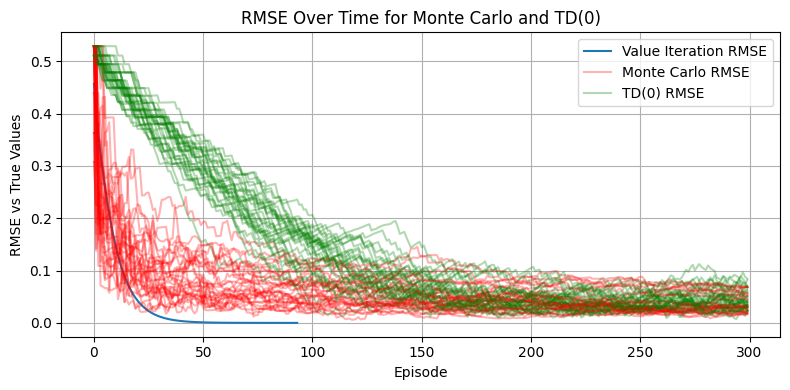

In [9]:
def compute_rmse(V_estimates, V_true):
    return [np.sqrt(np.mean((v[:-1] - V_true) ** 2)) for v in V_estimates]

V_true = np.arange(k-1) / (k - 1)
rmse_vi = compute_rmse(v_history, V_true)

# --- Plot RMSEs over time ---
plt.figure(figsize=(8, 4))
plt.plot(rmse_vi, label='Value Iteration RMSE')
n_trials = 30
for trial in range(n_trials):
  V_mc, v_history_mc, trajectory_history = monte_carlo_estimation(episodes=300)
  V_td0, v_history_td0 = td0_estimation(episodes=300)
  rmse_mc = compute_rmse(v_history_mc, V_true)
  rmse_td = compute_rmse(v_history_td0, V_true)

  plt.plot(rmse_mc, label='Monte Carlo RMSE', color='r', alpha=0.3)
  plt.plot(rmse_td, label='TD(0) RMSE', color='g', alpha=0.3)
  if trial == 0:
    plt.legend()
plt.xlabel('Episode')
plt.ylabel('RMSE vs True Values')
plt.title('RMSE Over Time for Monte Carlo and TD(0)')

plt.grid(True)
plt.tight_layout()
plt.show()